In [1]:
# this is just for visual appearance during development, can remove later
from IPython.display import HTML, display
display(HTML("<style>.container { width:100% !important; }</style>")) 

version 20230810
starting program:
2023-11-24 11:49:02 - DATA GATHERING
2023-11-24 11:49:02 - gathering fund holding data...

2023-11-24 11:49:03 - gathering FLEX option quotes...
2023-11-24 11:49:03 - attempting to connect to OCC...
2023-11-24 11:49:03 - successfully connected to https://marketdata.theocc.com/flex-reports?reportType=PR&optionType=E&reportDate=20231124
2023-11-24 11:49:03 - parsing response...
2023-11-24 11:49:03 - no data found for date 2023-11-24, trying one day prior
2023-11-24 11:49:03 - successfully connected to https://marketdata.theocc.com/flex-reports?reportType=PR&optionType=E&reportDate=20231123
2023-11-24 11:49:03 - parsing response...
2023-11-24 11:49:03 - no data found for date 2023-11-23, trying one day prior
2023-11-24 11:49:04 - successfully connected to https://marketdata.theocc.com/flex-reports?reportType=PR&optionType=E&reportDate=20231122
2023-11-24 11:49:04 - parsing response...
2023-11-24 11:49:04 - formatting FLEX quotes for 2023-11-22

2023-11-2

C:\Users\lrobertson\AppData\Local\Temp\ipykernel_18972\1486622130.py:292: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{y:.2%}' for y in yticks])


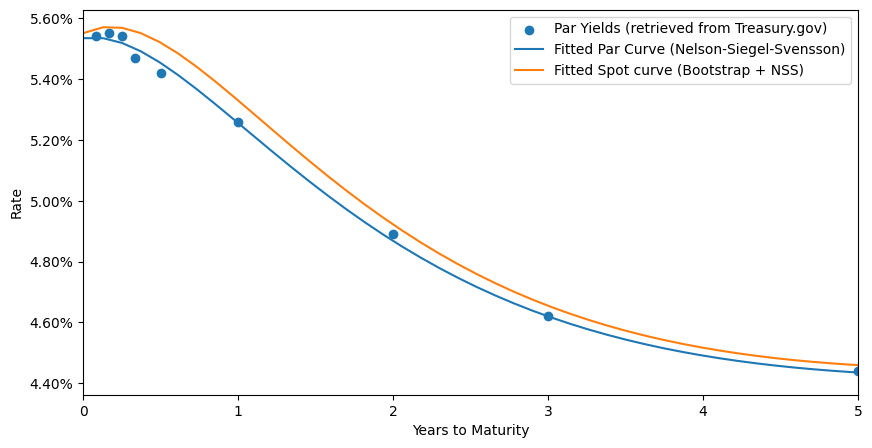

2023-11-24 11:49:16 - calibrating implied volatility surface...


C:\Users\lrobertson\AppData\Local\Temp\ipykernel_18972\1486622130.py:329: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_zticklabels([f'{z:.0%}' for z in ax1.get_zticks().tolist()])


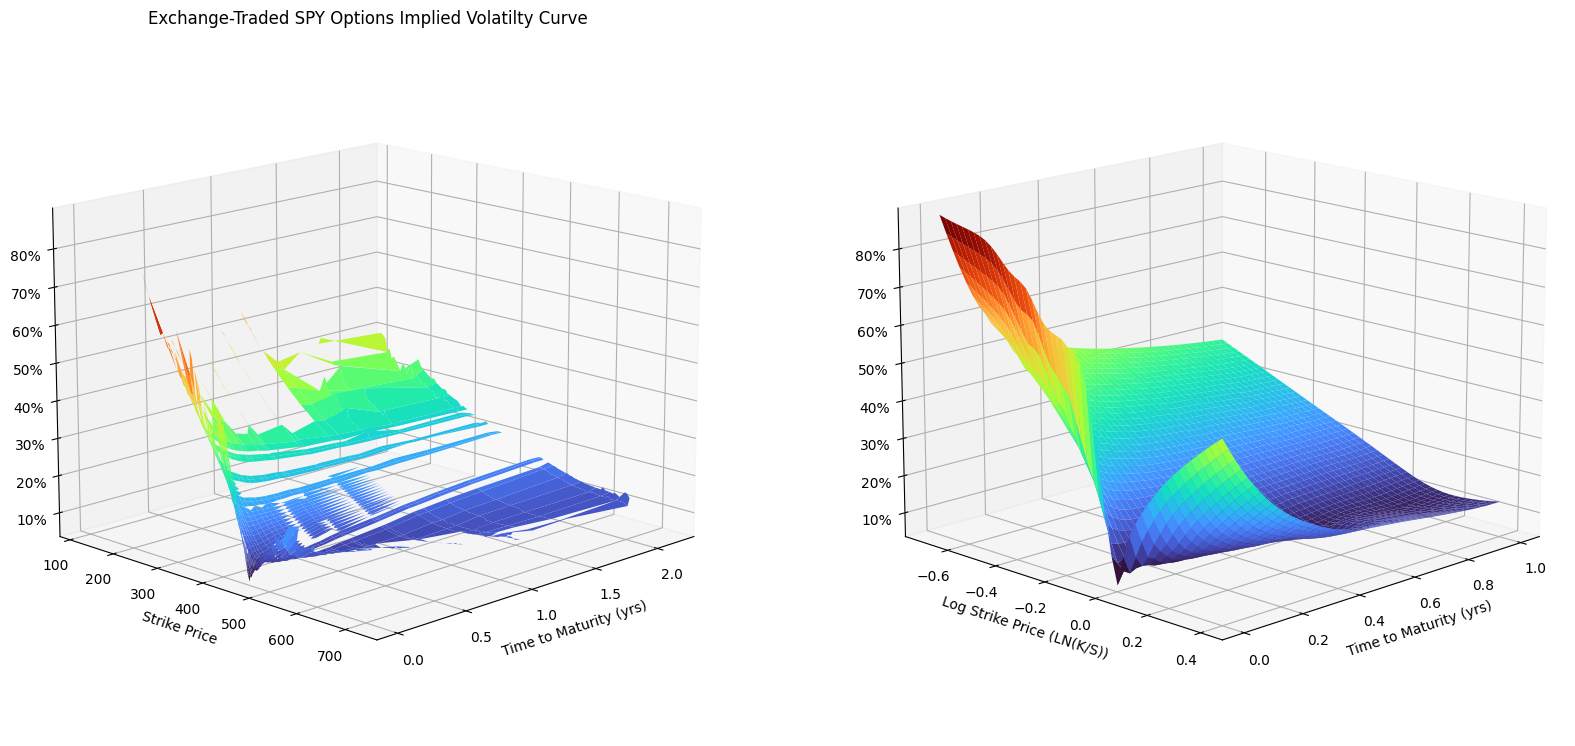

2023-11-24 11:49:17 - calculating option/fund statistics...


In [2]:
import requests
import json
import math
import xml.etree.ElementTree as ET
import datetime as dt
import numpy as np
import pandas as pd
from scipy import optimize
from scipy import interpolate
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import cm

class Option:
    def __init__(self, expir, isCall, strike):
        self.expir = expir
        self.isCall = isCall
        self.strike = strike
        self.value = 0.0
        self.ivol = 0.0
        
    def mark(self, mark_date, mark_spy, mark_divyld, mark_rate, mark_vol=None):
        c = 1 if self.isCall else -1
        t = (self.expir-mark_date).days/365
        k = self.strike
        s = mark_spy
        if t <= 0: #expired, return payoff value
            return max(c*(s-k),0)
        q = mark_divyld
        r = mark_rate
        v = mark_vol if mark_vol else self.ivol
        seqt = s*math.exp(-q*t)
        kert = k*math.exp(-r*t)
        d = (math.log(s/k)+t*(r-q+(v**2)/2))/(v*t**0.5)
        return c*seqt*norm.cdf(c*d)-c*kert*norm.cdf(c*(d-v*t**0.5))
    
    def calc_greeks(self, mark_date, mark_spy, mark_divyld, mark_rate):
        c = 1 if self.isCall else -1
        t = (self.expir-mark_date).days/365
        k = self.strike
        s = mark_spy
        q = mark_divyld
        r = mark_rate
        v = self.ivol
        d = (math.log(s/k)+t*(r-q+(v**2)/2))/(v*t**0.5)
        self.delta = c*math.exp(-q*t)*norm.cdf(c*d)
        self.vega = s*math.exp(-q*t)*norm.pdf(d)*t**0.5/100
        self.theta = (-math.exp(-q*t)*(s*norm.pdf(d)*v)/(2*t**0.5)-c*r*k*math.exp(-r*t)*norm.cdf(c*(d-v*t**0.5))+c*q*s*math.exp(-q*t)*norm.cdf(c*d))/365
        self.rho = c*k*t*math.exp(-r*t)*norm.cdf(c*(d-v*t**0.5))/100
    
    
    
class Fund:
    def __init__(self, ticker, holdings):
        self.ticker = ticker
        self.holdings = holdings
        self.value = 0.0
        
    def mark(self):
        self.value = sum([h.value*i for h,i in self.holdings.items()])

    def calc_greeks(self, spy_close): # AT THE FUND LEVEL, ALL GREEKS ARE SCALED TO PERCENTAGE CHANGE OF FUND VALUE, ALLOWS COMPARISON
        self.delta = sum([h.delta*i for h,i in self.holdings.items()])*spy_close/self.value
        self.vega = sum([h.vega*i for h,i in self.holdings.items()])/self.value
        self.theta = sum([h.theta*i for h,i in self.holdings.items()])/self.value
        self.rho = sum([h.delta*i for h,i in self.holdings.items()])/self.value

        

class Gatherer:
    def __init__(self, holdings_csv, log_file='log.txt'):
        self.holdings_csv = holdings_csv
        self.log_file = log_file
        self.launch()
    
    def log(self, msg):
        stamped_msg = f'{dt.datetime.now().replace(microsecond=0)} - {msg}'
        print(stamped_msg)
        
    def launch(self):
        print('version 20230810')
        print('starting program:')
        self.log('DATA GATHERING')
        self.funds = self.build_funds()
        if not self.funds:
            return False
        print()
        self.flex_quotes = self.get_flex_quotes()
        if not self.flex_quotes:
            return False
        print()
        self.par_curve = self.get_yield_curve()
        if not self.par_curve:
            return False
        print()
        self.spy_close, self.spy_chain = self.get_spy_chain()
        
        mark_successful = self.flex_mark()
        if not mark_successful:
            return False
        self.log('data successfully gathered!')
        self.log('ready to analyze')

    def build_funds(self):
        self.log('gathering fund holding data...')
        raw_funds = pd.read_csv(self.holdings_csv)
        raw_funds['expir'] = pd.to_datetime(raw_funds['expir'])
        if any([raw_funds.loc[i,'expir'].date()<dt.date.today() for i in raw_funds.index]):
            self.log('aborting due to an option in holdings csv expiring prior to today...')
            return None
        else:
            return [Fund(ticker, {Option(raw_funds.loc[pos,'expir'].date(),
                                         raw_funds.loc[pos,'call'],
                                         raw_funds.loc[pos,'strike']):raw_funds.loc[pos,'qty'] for pos in raw_funds.loc[raw_funds['ticker']==ticker].index
                                  }) for ticker in raw_funds['ticker'].unique()]
    
    def get_flex_quotes(self):
        self.log('gathering FLEX option quotes...')
        self.log('attempting to connect to OCC...')
        attempt_number = 0
        max_attempts = 5
        urlvar_reporttype = 'PR'
        urlvar_optiontype = 'E'
        urlvar_reportdate = lambda d: str(d.year)+str(d.month).zfill(2)+str(d.day).zfill(2)
        while attempt_number<max_attempts:
            target_date = dt.date.today()-dt.timedelta(days=attempt_number)
            url = f'https://marketdata.theocc.com/flex-reports?reportType={urlvar_reporttype}&optionType={urlvar_optiontype}&reportDate={urlvar_reportdate(target_date)}'
            response = requests.get(url)
            if response.status_code != 200:
                self.log(f'an error occured attempting to connect to {response.url}')
                self.log(f'error code: {response.status_code} - {response.reason}')
                return None
            else:
                self.log(f'successfully connected to {response.url}')
                self.log('parsing response...')
                quote_list = []
                for line in response._content.decode('utf-8').splitlines():
                    if '2SPY' in line:
                        quote_list.append(line)
                if len(quote_list)==0:
                    self.log(f'no data found for date {target_date}, trying one day prior')
                    attempt_number += 1
                    continue
                self.log(f'formatting FLEX quotes for {target_date}')
                flex_quotes = {}
                for i in quote_list:
                    quote = i.split()
                    expir = dt.date(int(quote[4]),int(quote[2]),int(quote[3]))
                    if expir not in flex_quotes.keys():
                        flex_quotes[expir] = {}
                    strike = float(quote[5])
                    if strike not in flex_quotes[expir].keys():
                        flex_quotes[expir][strike] = {}
                    flex_quotes[expir][strike][quote[1]=='C'] = float(quote[6])
                return flex_quotes
        self.log('max attempts to contact OCC reached, aborting...')
        return None
    
    def get_yield_curve(self):
        self.log('gathering yields...')
        self.log('attempting to connect to Treasury...')
        urlvar_data = 'daily_treasury_yield_curve'
        urlvar_year = str(dt.date.today().year)
        url = f'https://home.treasury.gov/resource-center/data-chart-center/interest-rates/pages/xml?data={urlvar_data}&field_tdr_date_value={urlvar_year}'
        response = requests.get(url)
        if response.status_code != 200:
            self.log(f'an error occured attempting to connect to {response.url}')
            self.log(f'error code: {response.status_code} - {response.reason}')
            return None
        else:
            self.log(f'successfully connected to {response.url}')
            raw_xml_str = response._content.decode('utf-8')
            # parsing treasury xml requires several different namespaces... very annoying
            ns_dict = {'main': raw_xml_str.split('xmlns=')[1].split('"')[1], #  need better solution... this is hacky and vulnerable to changes
                       'd': raw_xml_str.split('xmlns:d=')[1].split('"')[1], 
                       'm': raw_xml_str.split('xmlns:m=')[1].split('"')[1]}
            root = ET.fromstring(raw_xml_str)
            latest_entry = root.findall('main:entry', ns_dict)[-1]
            dt_updated = dt.datetime(*map(int, latest_entry.find('main:updated', ns_dict).text.replace('T','-').replace(':','-')[:-1].split('-')), tzinfo=dt.timezone.utc)
            data_date = dt.date(*map(int, latest_entry.find('main:content/m:properties/d:NEW_DATE', ns_dict).text.split('T')[0].split('-')))
            self.log(f'grabbing yield curve data for {data_date} (last updated at {dt_updated} UTC)')
            times = [0.0833, 0.1666, 0.25, 0.3333, 0.5, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0]
            par_curve = [(t, float(r.text)/100) for t,r in zip(times, latest_entry.find('main:content/m:properties', ns_dict)[1:-1])]
            return par_curve
        
    def get_spy_chain(self):
        self.log('attempting to connect to CBOE...')
        response = requests.get('https://www.cboe.com/delayed_quotes/spy/quote_table/')
        if response.status_code != 200:
            self.log(f'an error occured attempting to connect to {response.url}')
            self.log(f'error code: {response.status_code} - {response.reason}')
            return None
        else:
            self.log(f'successfully connected to {response.url}')
            self.log('parsing SPY option chain...')
            raw = response._content.decode().split('CTX.contextOptionsData = ')[1].split()[0].replace(';','')
            data = json.loads(raw)
            spy_close = float(data['data']['close'])
            symbol_splitter = lambda s: [s[6]=='C', dt.date(int(s[:2])+2000, int(s[2:4]), int(s[4:6])), int(s[7:12])+int(s[12:])/1000]
            chain_quotes = {}
            for q in data['data']['options']:
                if not (q['bid']==0 or q['ask']==0 or q['iv']==0): #exclude one sided quotes and n/a ivol
                    sym = symbol_splitter(q['option'].replace('SPY',''))
                    days = (sym[1]-dt.date.today()).days
                    if days>2:
                        if days not in chain_quotes.keys():
                            chain_quotes[days] = {}
                        if (sym[2] > spy_close) and sym[0]: # otm call
                            chain_quotes[days][sym[2]] = q['iv']
                        elif (sym[2] < spy_close) and not sym[0]: # otm put
                            chain_quotes[days][sym[2]] = q['iv']
            return spy_close, chain_quotes
        
    def flex_mark(self):
        self.log('marking fund holdings...')
        for fund in self.funds:
            for option in fund.holdings:
                try:
                    mark = launch.flex_quotes[option.expir][option.strike][option.isCall]
                except:
                    self.log(f'aborting... no FLEX quote found for option: {"CALL" if option.isCall else "PUT"} {option.expir} {option.strike}')
                    return None
                else:
                    option.value = mark
        return True
    


class Analyzer: # seperating out data gathering and analysis functionality because I don't want to make a billion API calls during development
    def __init__(self, funds, par_curve, spy_close, spy_divyld, spy_chain, show_plots=False):
        self.funds = funds
        self.par_curve = par_curve
        self.spy_close = spy_close
        self.spy_divyld = spy_divyld
        self.spy_chain = spy_chain
        self.show_plots = show_plots
        print()
        self.log('DATA ANALYSIS')
        self.launch()
    
    def launch(self):
        self.log('fitting model to par curve...')
        self.par_curve_params = self.fit_curve(self.par_curve)
        print(self.par_curve_params)
        self.log('bootstrapping spot curve...')
        self.spot_curve = self.bootstrap_spot(self.par_curve_params)
        self.log('fitting model to spot curve...')
        self.spot_curve_params = self.fit_curve(self.spot_curve)
        print(self.spot_curve_params)
        if self.show_plots:
            self.plot_yield_curves()
        self.log('calibrating implied volatility surface...')
        self.calibrate_ivol_surface(self.show_plots)
        self.log('calculating option/fund statistics...')
        self.calculate_fund_stats()
        
        return
        
    def log(self, msg):
        stamped_msg = f'{dt.datetime.now().replace(microsecond=0)} - {msg}'
        print(stamped_msg)
        
    def get_rate(self, t, param): # Nelson-Siegel-Svensson : https://en.wikipedia.org/wiki/Fixed-income_attribution#Modeling_the_yield_curve
        a = param[0]+param[1]*(1-math.exp(-t/param[4]))/(t/param[4])
        b = param[2]*((1-math.exp(-t/param[4]))/(t/param[4])-math.exp(-t/param[4]))
        c = param[3]*((1-math.exp(-t/param[5]))/(t/param[5])-math.exp(-t/param[5]))
        return(a+b+c)
    
    def fit_curve(self, known_points):
        guess = [0.02382,0.03002,0.04108,0.05387,0.74504,13.67487] #update periodically
        error_func = lambda params, known: sum([(self.get_rate(k[0],params)-k[1])**2 for k in known])
        result = optimize.minimize(error_func, guess, args=(known_points))
        return result['x']
    
    def bootstrap_spot(self, par_params):
        times = np.linspace(0.5,30,60)
        spots = []
        while len(spots)<len(times):
            c = self.get_rate(times[len(spots)], par_params)/2
            spots.append(((1+c)/(1-sum([c/((1+s)**t) for s,t in zip(spots,times)])))**(1/times[len(spots)])-1) # cheeky
        return(list(zip(times,spots)))
    
    def plot_yield_curves(self):
        fig = plt.figure(figsize=(10,5))
        ax = fig.add_subplot()
        ax.scatter([p[0] for p in self.par_curve], [p[1] for p in self.par_curve])
        times = np.linspace(0.01,30,250)
        ax.plot(times, [self.get_rate(t, self.par_curve_params) for t in times])
        ax.plot(times, [self.get_rate(t, self.spot_curve_params) for t in times])
        ax.set_xlim(0,5)
        yticks = ax.get_yticks().tolist()
        ax.set_yticklabels([f'{y:.2%}' for y in yticks])
        ax.legend(['Par Yields (retrieved from Treasury.gov)', 'Fitted Par Curve (Nelson-Siegel-Svensson)', 'Fitted Spot curve (Bootstrap + NSS)'])
        ax.set_xlabel('Years to Maturity')
        ax.set_ylabel('Rate')
        plt.show()
        
    def calibrate_ivol_surface(self, show_plots):
        known_points = np.concatenate([[(t/365,math.log(k/self.spy_close)) for k in K.keys()] for t,K in self.spy_chain.items()])
        known_values = np.concatenate([[v for v in V.values()] for V in self.spy_chain.values()])
        
        point_density = 48
        query_times = np.linspace(0.0,1,point_density)
        query_strikes = np.linspace(-0.7,0.4,point_density)
        # method 1
        qt, qs = np.meshgrid(query_times,query_strikes)
        #query_vols = interpolate.griddata(known_points, known_values, (qt, qs), method='cubic')
        # method 2
        self.vol_interp_func = interpolate.RBFInterpolator(known_points, known_values)
        vol_interp = self.vol_interp_func(np.array(np.meshgrid(query_times,query_strikes)).reshape(2,-1).T).reshape(point_density,point_density)
        
        if show_plots:
            plot_df = pd.DataFrame.from_dict(self.spy_chain)
            plot_df.sort_index(inplace=True)
            plot_x_ = [t/365 for t in plot_df.columns]
            plot_y_ = [k for k in plot_df.index]
            plot_x, plot_y = np.meshgrid(plot_x_, plot_y_)
            plot_z = np.array([[plot_df.loc[r,c] for c in plot_df.columns] for r in plot_df.index])
            
            # raw data
            fig = plt.figure(figsize=(20,30))
            ax1 = fig.add_subplot(1,2,1, projection='3d')
            ax1.view_init(15, 45)
            ax1.invert_xaxis()
            ax1.plot_surface(plot_x, plot_y, plot_z, cmap=cm.turbo)
            ax1.set_title('Exchange-Traded SPY Options Implied Volatilty Curve')
            ax1.set_ylabel('Strike Price')
            ax1.set_xlabel('Time to Maturity (yrs)')
            ax1.set_zticklabels([f'{z:.0%}' for z in ax1.get_zticks().tolist()])
            
            
            # interpolated data - RBF interpolator method
            ax2 = fig.add_subplot(1,2,2, projection='3d', sharez=ax1)
            ax2.invert_xaxis()
            ax2.view_init(15, 45)
            ax2.plot_surface(qt, qs, vol_interp, cmap=cm.turbo)
            ax2.set_ylabel('Log Strike Price (LN(K/S))')
            ax2.set_xlabel('Time to Maturity (yrs)')
            plt.show()
        return
    
    def calculate_fund_stats(self, override_flex=True):
        stat_date = dt.date.today()
        for fund in self.funds:
            for option in fund.holdings:
                scaled_time = (option.expir-stat_date).days/365
                scaled_strike = math.log(option.strike/self.spy_close)
                r = self.get_rate(scaled_time, self.spot_curve_params)
                option.ivol = self.vol_interp_func(np.array([[scaled_time, scaled_strike]]))[0]
                if override_flex:
                    option.value = option.mark(stat_date, self.spy_close, self.spy_divyld, r)
                option.calc_greeks(stat_date, self.spy_close, self.spy_divyld, r)
            fund.mark()
            fund.calc_greeks(self.spy_close)
            
    #def monte_carlo_single(self, trading_period=30):
    #    return


data = Gatherer(holdings_csv='holdings_231031.csv')
analysis = Analyzer(data.funds, data.par_curve, data.spy_close, 0.0148, data.spy_chain, show_plots=True)

In [3]:
import numpy.random as rand

#   VERY rough model came from personal research outside of the scope of this project
#   numbers derived from oberservations and many multiple regressions on daily SPY option data from 2005-2021
#   will need to revisit one day, but good enough for now
#   Only applicable/tested at forecast horizons at six months or less!
def forecast_ivol(horizon, time_to_expiration, log_strike, spy_logret, horizon_realized_vol, starting_ivol):
    h = horizon               # year fraction from forecast start to end
    t = time_to_expiration    # year fraction from forecast end to option expiration
    k = log_strike            # ln(strike/(spy at forecast end))
    ds = spy_logret           # ln((spy at forecast end)/(spy at forecast start))
    rv = horizon_realized_vol # standard deviation of daily log returns or spy, annualized at 250 trading days
    v0 = starting_ivol        # option implied volatility at forecast start
    t_ = (-0.0203846*h+0.0000255)*t
    k_ = (0.0179652*h-0.0000261)*k
    ds_ = (1.0569557*h-1.9013248)*ds
    rv_ = (1.159219*h*h-0.80513*h+0.015596)*rv
    i_ = (-0.241939*h*h+0.287693*h)
    dv = math.exp(t_+k_+ds_+rv_+i_)
    return v0*dv

def monte_carlo_single(period=30):
    # period = approx. number of simulation calendar days
    
    temp_test = pd.DataFrame(index=['spy','ticker',  ])
    start_date = dt.date.today()
    track_resets = {} # for adjusing fund values so they're continuous 
    sim_fund_dict = {f.ticker:f for f in analysis.funds}
    i = 0
    while i <= period:
        sim_date = start_date+dt.timedelta(days=i)
        if i==0:
            sim_dates_values = [sim_date]
            sim_return_values = []
            sim_spy_values = [analysis.spy_close]
            sim_fund_values = {fund.ticker:[fund.value] for fund in analysis.funds}
            i += 1
            continue
        if sim_date.weekday()>5:
            i += 1
            continue
        sim_time = (sim_date-start_date).days/365
        putt_rate = analysis.get_rate(sim_time, analysis.spot_curve_params)
        sim_return = rand.normal((math.exp(sim_time*(putt_rate-analysis.spy_divyld))-1)*0.004,analysis.vol_interp_func([[sim_time, 0]])[0]*0.063246)
        sim_spy = sim_spy_values[-1]*math.exp(sim_return)
        sim_dates_values.append(sim_date)
        sim_return_values.append(sim_return)
        sim_spy_values.append(sim_spy)
        
        realized_vol = np.std(sim_return_values)*15.811388
        spy_logret = math.log(sim_spy/sim_spy_values[0])
        
        for ticker, fund in sim_fund_dict.items():
            fund_value = 0.0
            is_expired = False
            for option, exposure in fund.holdings.items():
                t = (option.expir-sim_date).days/365
                if t == 0:
                    fund_value = sum([exposure*max((1 if o.isCall else -1)*(sim_spy-o.strike),0) for o, exposure in fund.holdings.items()])
                    is_expired = True
                    sim_fund_values[fund.ticker].append(fund_value)
                    break
                else:
                    pitch_rate = analysis.get_rate((option.expir-start_date).days/365, analysis.spot_curve_params)
                    mark_rate = (((1+pitch_rate)**((option.expir-start_date).days/365))/((1+putt_rate)**sim_time))**(1/t)-1
                    log_strike = math.log(option.strike/sim_spy)
                    vol = forecast_ivol(sim_time, t, log_strike, spy_logret, realized_vol, analysis.vol_interp_func(np.array([[t,log_strike]]))[0])
                    fund_value += exposure*option.mark(sim_date, sim_spy, analysis.spy_divyld, mark_rate, mark_vol=vol) 
            if not is_expired:
                sim_fund_values[fund.ticker].append(fund_value)
            else: 
                # reset the fund exposures, pretty messy
                new_expir = dt.date(sim_date.year+1, sim_date.month, sim_date.day)
                new_t = (new_expir-sim_date).days/365
                pitch_rate = analysis.get_rate((new_expir-start_date).days/365, analysis.spot_curve_params)
                mark_rate = (((1+pitch_rate)**((new_expir-start_date).days/365))/((1+putt_rate)**sim_time))**(1/new_t)-1
                new_long_call = Option(new_expir, True, round(sim_spy*.01,2))
                new_long_call.ivol = forecast_ivol(sim_time, new_t, math.log(new_long_call.strike/sim_spy), 
                                                   spy_logret, realized_vol, analysis.vol_interp_func(np.array([[new_t,math.log(new_long_call.strike/sim_spy)]]))[0])
                new_long_call.value = new_long_call.mark(sim_date, sim_spy, analysis.spy_divyld, mark_rate, new_long_call.ivol)
                new_short_put = Option(new_expir, False, round(sim_spy*.85 if (fund.ticker[0]=='P') else sim_spy*.91,2))
                new_short_put.ivol = forecast_ivol(sim_time, new_t, math.log(new_short_put.strike/sim_spy), 
                                                   spy_logret, realized_vol, analysis.vol_interp_func(np.array([[new_t,math.log(new_short_put.strike/sim_spy)]]))[0])
                new_short_put.value = new_short_put.mark(sim_date, sim_spy, analysis.spy_divyld, mark_rate, new_short_put.ivol)
                new_long_put = Option(new_expir, False, round(sim_spy,2))
                new_long_put.ivol = forecast_ivol(sim_time, new_t, math.log(new_long_put.strike/sim_spy), 
                                                   spy_logret, realized_vol, analysis.vol_interp_func(np.array([[new_t,math.log(new_long_put.strike/sim_spy)]]))[0])
                new_long_put.value = new_long_put.mark(sim_date, sim_spy, analysis.spy_divyld, mark_rate, new_long_put.ivol)
                
                goal_shortcall_value = -(sim_spy*0.99-new_long_call.value+new_short_put.value-new_long_put.value)
                new_short_call = Option(new_expir, True, 0.0)
                def find_shortcall_strike(guess_strike, shortcall, goal):
                    shortcall.strike = guess_strike
                    shortcall.ivol = forecast_ivol(sim_time, new_t, math.log(shortcall.strike/sim_spy), 
                                                   spy_logret, realized_vol, analysis.vol_interp_func(np.array([[new_t,math.log(shortcall.strike/sim_spy)]]))[0])
                    shortcall.value = shortcall.mark(sim_date, sim_spy, analysis.spy_divyld, mark_rate, new_long_put.ivol)
                    return (goal-shortcall.value)**2
                optimize.minimize(find_shortcall_strike, sim_spy*1.2, args=(new_short_call, goal_shortcall_value))
                # for some reason optimizer sets strike and value to lists, so fix
                new_short_call.strike =  new_short_call.strike[0]
                new_short_call.value =  new_short_call.value[0]
                #print(ticker, new_short_call.strike)
                sim_fund_dict[ticker] = Fund(fund.ticker, {new_long_call: 1, new_short_call: -1, new_short_put: -1, new_long_put: 1})
                
                fund_value = sum([exposure*option.value for option,exposure in sim_fund_dict[ticker].holdings.items()])
                
                
                
                
                last_value = sim_fund_values[fund.ticker][-1]
                track_resets[ticker] = {'old': last_value, 'new':None}
                #if ticker=='POCT':
                #    print(sim_date, 'reset', sim_fund_values['POCT'][-1])
                continue
                

            if ticker in track_resets.keys():
                #if ticker=='POCT':
                    #print(sim_date, 'scaling before', sim_fund_values['POCT'][-1])
                    #print(sim_fund_values[fund.ticker][-1])
                    #print('old ', track_resets[ticker]['old'])
                    #print('new ', track_resets[ticker]['new'])
                if track_resets[ticker]['new']==None:
                    track_resets[ticker]['new'] = sim_fund_values[fund.ticker][-1]
                sim_fund_values[fund.ticker][-1] = sim_fund_values[fund.ticker][-1]/track_resets[ticker]['new']*track_resets[ticker]['old']
                #if ticker=='POCT':
                #    print(sim_date, 'scaling after', sim_fund_values['POCT'][-1])
                
        i += 1
        
    period_rf = (1+putt_rate)**sim_time-1  
    sim_spy_stats = {}
    sim_spy_stats['total_return'] = (sim_spy_values[-1]/sim_spy_values[0])-1
    sim_spy_stats['max_drawdown'] = min([j/max(sim_spy_values[:i+1])-1 for i,j in enumerate(sim_spy_values)])
    sim_spy_stats['std_dev'] = np.std([math.log(j/sim_spy_values[max(0,i-1)]) for i,j in enumerate(sim_spy_values)][1:])*250**0.5
    sim_spy_stats['sharpe'] = (sim_spy_stats['total_return']-period_rf)/(sim_spy_stats['std_dev']/(1/sim_time)**0.5)

    sim_fund_stats = {ticker:{} for ticker in list(sim_fund_values.keys())}
    for fund, values in sim_fund_values.items():
        sim_fund_stats[fund]['total_return'] = (values[-1]/values[0])-1
        sim_fund_stats[fund]['max_drawdown'] = min([j/max(values[:i+1])-1 for i,j in enumerate(values)])
        sim_fund_stats[fund]['std_dev'] = np.std([math.log(j/values[max(0,i-1)]) for i,j in enumerate(values)][1:])*250**0.5
        sim_fund_stats[fund]['sharpe'] = (sim_fund_stats[fund]['total_return']-period_rf)/(sim_fund_stats[fund]['std_dev']/(1/sim_time)**0.5)

    #plt.plot(sim_dates_values, [i/sim_spy_values[0]-1 for i in sim_spy_values])
    #plt.plot(sim_dates_values, sim_fund_values['BAUG'])
    #plt.plot(sim_dates_values, [i/sim_fund_values['POCT'][0]-1 for i in sim_fund_values['POCT']])
    #plt.plot(sim_dates_values, [i/sim_fund_values['PSEP'][0]-1 for i in sim_fund_values['PSEP']])
    #plt.plot(sim_dates_values, sim_fund_values['BOCT'])
    #plt.plot(sim_dates_values, sim_fund_values['BNOV'])
    #plt.legend(['SPY', 'BAUG', 'BSEP', 'BOCT', 'BNOV'])

    #print(track_resets)
    return sim_spy_stats, sim_fund_stats

def monte_carlo_multiple(runs=1, period=30):
    spy_stats = [np.nan]*runs
    fund_stats = [np.nan]*runs
    for i in range(runs):
        spy_stats[i], fund_stats[i] = monte_carlo_single(period=period)
        print(f'progress: {(i+1)/runs:.1%}')
        
    return spy_stats, fund_stats


spy_stats, fund_stats  = monte_carlo_multiple(runs=1000, period=30)

progress: 0.1%
progress: 0.2%
progress: 0.3%
progress: 0.4%
progress: 0.5%
progress: 0.6%
progress: 0.7%
progress: 0.8%
progress: 0.9%
progress: 1.0%
progress: 1.1%
progress: 1.2%
progress: 1.3%
progress: 1.4%
progress: 1.5%
progress: 1.6%
progress: 1.7%
progress: 1.8%
progress: 1.9%
progress: 2.0%
progress: 2.1%
progress: 2.2%
progress: 2.3%
progress: 2.4%
progress: 2.5%
progress: 2.6%
progress: 2.7%
progress: 2.8%
progress: 2.9%
progress: 3.0%
progress: 3.1%
progress: 3.2%
progress: 3.3%
progress: 3.4%
progress: 3.5%
progress: 3.6%
progress: 3.7%
progress: 3.8%
progress: 3.9%
progress: 4.0%
progress: 4.1%
progress: 4.2%
progress: 4.3%
progress: 4.4%
progress: 4.5%
progress: 4.6%
progress: 4.7%
progress: 4.8%
progress: 4.9%
progress: 5.0%
progress: 5.1%
progress: 5.2%
progress: 5.3%
progress: 5.4%
progress: 5.5%
progress: 5.6%
progress: 5.7%
progress: 5.8%
progress: 5.9%
progress: 6.0%
progress: 6.1%
progress: 6.2%
progress: 6.3%
progress: 6.4%
progress: 6.5%
progress: 6.6%
progress: 

In [4]:
ticker_list = [ticker for ticker in fund_stats[0]]
z_bound_lower = -1
z_bound_upper = 1
spy_mean = np.mean([spy['total_return'] for spy in spy_stats])
spy_std = np.std([spy['total_return'] for spy in spy_stats])

spreads = [[f['total_return']-spy['total_return'] for f in fund.values()] for spy,fund in zip(spy_stats, fund_stats) if 
           (spy['total_return']>=(spy_mean+z_bound_lower*spy_std)) and (spy['total_return']<=(spy_mean+z_bound_upper*spy_std))]

test = {ticker:np.mean([s[i] for s in spreads]) for i, ticker in enumerate(ticker_list)}
for j,i in enumerate(test.values()):
    print(i)

0.001675817244492959
0.0014731390938814775
0.003084392486259379
0.002194626337168346
0.0020033380244183024
0.002333300840497428
0.0014460250133615212
0.0018686624699024669
0.0014257012647400863
0.0019952890480133298
0.004313822365137437
0.0011798030594245548
0.007845356947281524
0.004907807052379167
0.005970819658875095
0.0044533749038534595
0.00349509557681337
0.004074361082975034
0.0021166611362470034
0.002670398413300868
0.0016874518844169236
0.0032941106947452546
0.004644361373844148
0.0013472521828562984


In [95]:
test

{'BJAN': 0.0020175921227688818,
 'BFEB': 0.0014968490478102533,
 'BMAR': 0.0028631242108585787,
 'BAPR': 0.002137084498324989,
 'BMAY': 0.0019246613394699294,
 'BJUN': 0.002206205458980884,
 'BJUL': 0.001469431717060979,
 'BAUG': 0.0017421701323802627,
 'BSEP': 0.00160372610002245,
 'BOCT': 0.0022667795791876883,
 'BNOV': 0.0043856613896590315,
 'BDEC': 0.0013138986173795286,
 'PJAN': 0.007263467373193685,
 'PFEB': 0.004344898510955734,
 'PMAR': 0.005397464177870276,
 'PAPR': 0.00399321864306654,
 'PMAY': 0.0033420566618426535,
 'PJUN': 0.003738540824544771,
 'PJUL': 0.0019970143367163936,
 'PAUG': 0.002192309705945778,
 'PSEP': 0.0018424605298566657,
 'POCT': 0.0029755735802959086,
 'PNOV': 0.004892616155047445,
 'PDEC': 0.0015473549741573393}

In [ ]:
pd.DataFrame(test).to_csv('test.csv')

In [101]:
ticker_list = [ticker for ticker in fund_stats[0]]
sorted_returns = sorted(zip([run['total_return'] for run in spy_stats],list(zip(*[[run[ticker]['total_return'] for run in fund_stats] for ticker in ticker_list]))))
sorted_fund_returns = [i[1] for i in sorted_returns]
sorted_spy_returns = [i[0] for i in sorted_returns]

pd.DataFrame(sorted_fund_returns).to_csv('test.csv')

In [102]:
pd.DataFrame(sorted_spy_returns).to_csv('test.csv')

In [13]:

z_bound_lower = -1
z_bound_upper = 1

spy_zscores = [(i-np.mean(sorted_spy_returns))/np.std(sorted_spy_returns) for i in sorted_spy_returns]
spy_pdf = [(i,norm.pdf(z)) for i,z in enumerate(spy_zscores) if (z >= z_bound_lower) and (z <= z_bound_upper)]
sum_spy_pdf = sum([i[1] for i in spy_pdf])
for i, ticker in enumerate(ticker_list):
    
    wgt_spread_over_spy = sum([(sorted_fund_returns[j[0]][i]-sorted_spy_returns[j[0]])*j[1]/sum_spy_pdf for j in spy_pdf])
    
    print(f'{ticker} {wgt_spread_over_spy:.5%}')


    


BJAN 0.27458%
BFEB 0.16019%
BMAR 0.35305%
BAPR 0.23019%
BMAY 0.29860%
BJUN 0.25836%
BJUL 0.13316%
BAUG 0.18330%
BSEP 0.21064%
BOCT 0.31855%
BNOV 0.56504%
BDEC 0.23502%
PJAN 0.87529%
PFEB 0.52823%
PMAR 0.70996%
PAPR 0.47065%
PMAY 0.50094%
PJUN 0.41409%
PJUL 0.13077%
PAUG 0.20322%
PSEP 0.22808%
POCT 0.37624%
PNOV 0.60238%
PDEC 0.28812%


In [24]:
[(i.strike, i.expir) for i in analysis.funds[10].holdings]

[(3.87, datetime.date(2023, 10, 31)),
 (497.01, datetime.date(2023, 10, 31)),
 (386.22, datetime.date(2023, 10, 31)),
 (351.45, datetime.date(2023, 10, 31))]

In [53]:
results = {}
for t in [45]:
    spy_stats, fund_stats  = monte_carlo_multiple(runs=10, period=t)
    #print([[(s['total_return'], ticker, f['total_return']) for ticker,f in fund_stats[i].items()]for i,s in enumerate(spy_stats)])
    
    t_res = {ticker:[(s['total_return'], funds[ticker]['total_return']) for s, funds in zip(spy_stats, fund_stats)] for ticker in ticker_list}
    print(t_res)
    

progress: 10.0%
progress: 20.0%
progress: 30.0%
progress: 40.0%
progress: 50.0%
progress: 60.0%
progress: 70.0%
progress: 80.0%
progress: 90.0%
progress: 100.0%
{'BJAN': [(-0.05631047825672286, -0.051689752357960805), (-0.08198739460239712, -0.07267899768169428), (-0.049354446988307044, -0.0456670869717104), (-0.028698720218106488, -0.02712882037182296), (0.054719651079057074, 0.052259893359409615), (-0.019709007075965124, -0.018814763772917797), (0.04939561044632579, 0.04732360155257598), (0.03237219086978649, 0.031095124727388734), (0.030898248033624398, 0.029671261724135256), (-0.03464602878270162, -0.032559777966379544)], 'BFEB': [(-0.05631047825672286, -0.043421531698500715), (-0.08198739460239712, -0.06049052222816009), (-0.049354446988307044, -0.03841805840521584), (-0.028698720218106488, -0.0227056064637996), (0.054719651079057074, 0.047352133265232466), (-0.019709007075965124, -0.015556507882298232), (0.04939561044632579, 0.042878944787939854), (0.03237219086978649, 0.02832359

In [54]:
t_res['BJAN']

[(-0.05631047825672286, -0.051689752357960805),
 (-0.08198739460239712, -0.07267899768169428),
 (-0.049354446988307044, -0.0456670869717104),
 (-0.028698720218106488, -0.02712882037182296),
 (0.054719651079057074, 0.052259893359409615),
 (-0.019709007075965124, -0.018814763772917797),
 (0.04939561044632579, 0.04732360155257598),
 (0.03237219086978649, 0.031095124727388734),
 (0.030898248033624398, 0.029671261724135256),
 (-0.03464602878270162, -0.032559777966379544)]

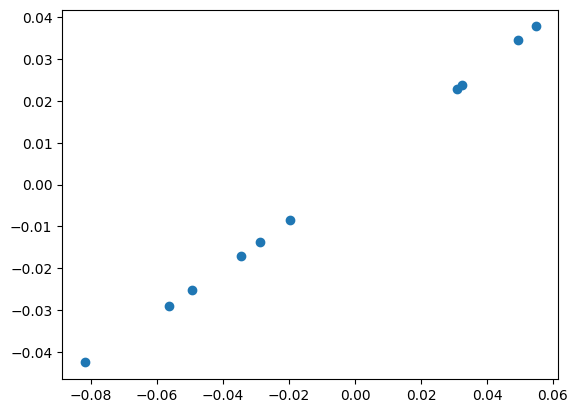

In [58]:

plt.scatter([xy[0] for xy in t_res['PAUG']], [xy[1] for xy in t_res['PAUG']])

In [59]:
coefs = np.polyfit([xy[0] for xy in t_res['PAUG']], [xy[1] for xy in t_res['PAUG']], 3)

In [60]:
for i in coefs:
    print(i)

-2.2580624579133626
0.41984273151801765
0.609845918438208
0.0035613041733485143


In [39]:
pd.DataFrame.from_dict(fund_coefs).to_csv('test.csv')

In [20]:
analysis.spy_divyld

0.0146

In [ ]:
import ipywidgets as widgets
from ipywidgets import Layout

def chart_interact(rot_v, rot_h, h, spy, rvol):
    #point_density = 12
    #query_times = np.linspace(0,1,point_density)
    #query_strikes = np.linspace(-0.7,0.4,point_density)
    #qt, qs = np.meshgrid(query_times,query_strikes)
    #vol_interp = analysis.vol_interp_func(np.array(np.meshgrid(query_times,query_strikes)).reshape(2,-1).T).reshape(point_density,point_density)
    
    #vol_new = np.array([[vol_interp[time_index][strike_index] for strike_index in range(point_density)] for time_index in range(point_density)])
    
    vol_new = np.array([[v if (v:=forecast_ivol(h, 
                                       query_times[time_index], 
                                       query_strikes[strike_index], 
                                       spy, 
                                       rvol, 
                                       analysis.vol_interp_func([[query_times[time_index]-h, query_strikes[strike_index]-spy]])[0]
                                      ) if query_times[time_index]-h>=0 else np.nan)<1.5 else np.nan
                         for time_index in range(point_density)] for strike_index in range(point_density)])
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    ax.invert_xaxis()
    ax.set_zlim(0,1)
    ax.view_init(rot_v, rot_h)
    ax.plot_surface(qt, qs, vol_new, cmap=cm.turbo)
    return

point_density = 48
query_times = np.linspace(0,1,point_density)
query_strikes = np.linspace(-0.7,0.4,point_density)
qt, qs = np.meshgrid(query_times,query_strikes)
vol_interp = analysis.vol_interp_func(np.array(np.meshgrid(query_times,query_strikes)).reshape(2,-1).T).reshape(point_density,point_density)

style = dict(description_width='initial')



main = widgets.HBox([widgets.VBox([rot_vertical:=widgets.IntSlider(value=15, min=0, max=90, step=1, readout=False, description='Vertical Rotation',style=style, layout=Layout(width='95%')),
                                   rot_horizontal:=widgets.IntSlider(value=45, min=0, max=360, step=1, readout=False, description='Horizontal Rotation',style=style, layout=Layout(width='95%')),
                                   widgets.Label('Model Inputs:', layout=Layout(width='500px')),
                                   h_slider := widgets.FloatSlider(value=0, min=0, max=1, step=1/12, description='Forecast Horizon (yrs)', style=style, layout=Layout(width='95%')),
                                   spy_slider := widgets.FloatSlider(value=0, min=-0.7, max=0.4, step=0.01, description='SPY Log Return', style=style, layout=Layout(width='95%')),
                                   rvol_slider := widgets.FloatSlider(value=0.20, min=0.07, max=0.80, step=0.01, description='Horizon Realized Volatility', style=style, layout=Layout(width='95%'))]),
                     widgets.interactive_output(chart_interact, {'rot_v':rot_vertical,
                                                                 'rot_h':rot_horizontal,
                                                                 'h':h_slider,
                                                                 'spy': spy_slider,
                                                                 'rvol': rvol_slider})])
display(main)

In [ ]:
#   VERY rough model came from personal research outside of the scope of this project
#   numbers derived from oberservations and many multiple regressions on daily SPY option data from 2005-2021
#   will need to revisit one day, but good enough for now
#   Only applicable/tested at forecast horizons at six months or less!
def forecast_ivol(horizon, time_to_expiration, log_strike, spy_logret, horizon_realized_vol, starting_ivol):
    h = horizon               # year fraction from forecast start to end
    t = time_to_expiration    # year fraction from forecast end to option expiration
    k = log_strike            # ln(strike/(spy at forecast end))
    ds = spy_logret           # ln((spy at forecast end)/(spy at forecast start))
    rv = horizon_realized_vol # standard deviation of daily log returns or spy, annualized at 250 trading days
    v0 = starting_ivol        # option implied volatility at forecast start
    t_ = (-0.0203846*h+0.0000255)*t
    k_ = (0.0179652*h-0.0000261)*k
    ds_ = (1.0569557*h-1.9013248)*ds
    rv_ = (1.159219*h*h-0.80513*h+0.015596)*rv
    i_ = (-0.241939*h*h+0.287693*h)
    dv = math.exp(t_+k_+ds_+rv_+i_)
    return v0*dv

In [ ]:
def calibrate_ivol_surface(self, show_plots):
        known_points = np.concatenate([[(t/365,math.log(k/self.spy_close)) for k in K.keys()] for t,K in self.spy_chain.items()])
        known_values = np.concatenate([[v for v in V.values()] for V in self.spy_chain.values()])
        
        point_density = 48
        query_times = np.linspace(0,1,point_density)
        query_strikes = np.linspace(-0.7,0.4,point_density)
        # method 1
        qt, qs = np.meshgrid(query_times,query_strikes)
        #query_vols = interpolate.griddata(known_points, known_values, (qt, qs), method='cubic')
        # method 2
        self.vol_interp_func = interpolate.RBFInterpolator(known_points, known_values)
        vol_interp = self.vol_interp_func(np.array(np.meshgrid(query_times,query_strikes)).reshape(2,-1).T).reshape(point_density,point_density)
        
        if show_plots:
            plot_df = pd.DataFrame.from_dict(self.spy_chain)
            plot_df.sort_index(inplace=True)
            plot_x_ = [t/365 for t in plot_df.columns]
            plot_y_ = [k for k in plot_df.index]
            plot_x, plot_y = np.meshgrid(plot_x_, plot_y_)
            plot_z = np.array([[plot_df.loc[r,c] for c in plot_df.columns] for r in plot_df.index])
            # raw data
            fig = plt.figure(figsize=(20,30))
            ax1 = fig.add_subplot(1,2,1, projection='3d')
            ax1.view_init(15, 45)
            ax1.invert_xaxis()
            ax1.plot_surface(plot_x, plot_y, plot_z, cmap=cm.turbo)
            
            # interpolated data - RBF interpolator method
            ax2 = fig.add_subplot(1,2,2, projection='3d', sharez=ax1)
            ax2.invert_xaxis()
            ax2.view_init(15, 45)
            ax2.plot_surface(qt, qs, vol_interp, cmap=cm.turbo)
            plt.show()
        return

In [ ]:
vol_interp_func

In [15]:
#   VERY rough model came from personal research outside of the scope of this project
#   numbers derived from oberservations and many multiple regressions on daily SPY option data from 2005-2021
#   will need to revisit one day, but good enough for now
#   Only applicable/tested at forecast horizons at six months or less!
def forecast_ivol2(horizon, time_to_expiration, log_strike, spy_logret, horizon_realized_vol, starting_ivol):
    h = horizon               # year fraction from forecast start to end
    t = time_to_expiration    # year fraction from forecast end to option expiration
    k = log_strike            # ln(strike/(spy at forecast end))
    ds = spy_logret           # ln((spy at forecast end)/(spy at forecast start))
    rv = horizon_realized_vol # standard deviation of daily log returns or spy, annualized at 250 trading days
    v0 = starting_ivol        # option implied volatility at forecast start
    t_ = 0 # (-0.0203846*h+0.0000255)*t
    k_ = 0 #(0.0179652*h-0.0000261)*k
    ds_ = (1.0569557*h-1.9013248)*ds
    rv_ = (1.159219*h*h-0.80513*h+0.015596)*rv
    i_ = (-0.241939*h*h+0.287693*h)
    dv = math.exp(t_+k_+ds_+rv_+i_)
    return v0*dv

forecast_ivol2(0.5,0.5,0,0,0.2,0.2)

0.21320332045730997

In [31]:
for f in analysis.funds:
    print(f.ticker)
    print('delta: {:.0f}'.format(f.delta*100))
    print('vega: {:.0f}'.format(f.vega*10000))
    print('theta: {:.0f}'.format(f.theta*10000))
    print('rho: {:.0f}'.format(f.rho*10000))

BJAN
delta: 90
vega: 4
theta: -0
rho: 22
BFEB
delta: 77
vega: 6
theta: 0
rho: 18
BMAR
delta: 81
vega: 3
theta: 0
rho: 19
BAPR
delta: 77
vega: 3
theta: 1
rho: 18
BMAY
delta: 74
vega: 1
theta: 1
rho: 18
BJUN
delta: 74
vega: -1
theta: 1
rho: 18
BJUL
delta: 70
vega: -2
theta: 1
rho: 17
BAUG
delta: 69
vega: -5
theta: 1
rho: 16
BSEP
delta: 71
vega: -4
theta: 1
rho: 17
BOCT
delta: 73
vega: -8
theta: 1
rho: 17
BNOV
delta: nan
vega: nan
theta: nan
rho: nan
BDEC
delta: 76
vega: 7
theta: -1
rho: 18
PJAN
delta: 83
vega: 1
theta: 0
rho: 20
PFEB
delta: 67
vega: 6
theta: 0
rho: 16
PMAR
delta: 66
vega: -1
theta: 1
rho: 16
PAPR
delta: 62
vega: 1
theta: 1
rho: 15
PMAY
delta: 59
vega: -1
theta: 1
rho: 14
PJUN
delta: 59
vega: -3
theta: 1
rho: 14
PJUL
delta: 56
vega: 0
theta: 1
rho: 13
PAUG
delta: 53
vega: -3
theta: 1
rho: 13
PSEP
delta: 56
vega: -4
theta: 1
rho: 13
POCT
delta: 56
vega: -11
theta: 1
rho: 13
PNOV
delta: nan
vega: nan
theta: nan
rho: nan
PDEC
delta: 73
vega: 8
theta: -2
rho: 18


In [1083]:
ticker_list = [ticker for ticker in fund_stats[0]]
num_buckets = 5
size_bucket = int(len(spy_stats)/num_buckets)
sorted_returns = sorted(zip([run['total_return'] for run in spy_stats],list(zip(*[[run[ticker]['total_return'] for run in fund_stats] for ticker in ticker_list]))))
bucketed_returns = [sorted_returns[i:i+size_bucket] for i in range(0,len(sorted_returns),size_bucket)]

#outperform_matrix = {i:pd.DataFrame(index=ticker_list, columns=ticker_list) for i in range(num_buckets)}

for i, bucket in enumerate(bucketed_returns):
    bkt_spy_avg = np.mean([run[0] for run in bucket])
    bkt_funds_avg = {ticker:np.mean(returns) for ticker, returns in zip(ticker_list,list(zip(*[run[1] for run in bucket])))}
    bkt_funds_std = {ticker:np.std(returns) for ticker, returns in zip(ticker_list,list(zip(*[run[1] for run in bucket])))}
    
    
  
    
    for r in outperform_matrix[i].index:
        for c in outperform_matrix[i].columns:
            outperform_matrix[i].loc[r,c] = (bkt_funds_avg[r]-bkt_funds_avg[c])
            #  https://stats.stackexchange.com/questions/24693/probability-that-random-variable-b-is-greater-than-random-variable-a
            #  https://en.wikipedia.org/wiki/Stress%E2%80%93strength_analysis
            outperform_matrix[i].loc[r,c] = 1-norm.cdf((bkt_funds_avg[c]-bkt_funds_avg[r])/(bkt_funds_std[c]+bkt_funds_std[r])**0.5)

    
outperform_matrix[0]

,BJAN,BFEB,BMAR,BAPR,BMAY,BJUN,BJUL,BAUG,BSEP,BOCT,...,PMAR,PAPR,PMAY,PJUN,PJUL,PAUG,PSEP,POCT,PNOV,PDEC
BJAN,0.5,0.492098,0.486537,0.488691,0.48472,0.485224,0.488042,0.486446,0.505265,0.512158,...,0.453686,0.458805,0.456232,0.457222,0.467131,0.466826,0.49997,0.449861,0.5019,0.494463
BFEB,0.507902,0.5,0.494202,0.496488,0.492423,0.49296,0.495997,0.494401,0.513131,0.520094,...,0.460651,0.465975,0.46334,0.464389,0.474715,0.474438,0.50775,0.456244,0.50995,0.502736
BMAR,0.513463,0.505798,0.5,0.502318,0.49831,0.498857,0.501968,0.500426,0.518525,0.525355,...,0.467057,0.472376,0.469792,0.470861,0.481174,0.480938,0.51323,0.46213,0.515555,0.508723
BAPR,0.511309,0.503512,0.497682,0.5,0.495947,0.496493,0.499592,0.49802,0.516459,0.523373,...,0.464306,0.469655,0.467034,0.4681,0.478477,0.478222,0.511105,0.459593,0.513396,0.506381
BMAY,0.51528,0.507577,0.50169,0.504053,0.5,0.500558,0.50374,0.50219,0.520355,0.527232,...,0.468387,0.473785,0.471169,0.472257,0.48273,0.482499,0.515014,0.463326,0.51742,0.510613
BJUN,0.514776,0.50704,0.501143,0.503507,0.499442,0.5,0.50318,0.501623,0.519873,0.526773,...,0.467726,0.473133,0.470507,0.471595,0.482087,0.481851,0.514517,0.462716,0.516916,0.510064
BJUL,0.511958,0.504003,0.498032,0.500408,0.49626,0.49682,0.5,0.498391,0.517198,0.524241,...,0.463829,0.469305,0.466612,0.4677,0.478335,0.478069,0.511735,0.459129,0.514104,0.506969
BAUG,0.513554,0.505599,0.499574,0.50198,0.49781,0.498377,0.501609,0.5,0.518786,0.525846,...,0.465207,0.47073,0.468022,0.469123,0.479857,0.479597,0.513303,0.460376,0.515734,0.508652
BSEP,0.494735,0.486869,0.481475,0.483541,0.479645,0.480127,0.482802,0.481214,0.5,0.506823,...,0.449206,0.45418,0.451657,0.452608,0.462223,0.461904,0.49478,0.445726,0.496538,0.489002
BOCT,0.487842,0.479906,0.474645,0.476627,0.472768,0.473227,0.475759,0.474154,0.493177,0.5,...,0.442587,0.447447,0.444943,0.445855,0.455242,0.454895,0.48798,0.439598,0.489549,0.481776


In [1081]:
outperform_matrix[0].to_csv('test2.csv')